In [178]:
import numpy as np
import math
from random import choice
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
plt.style.use('seaborn')

In [32]:
data = pd.read_excel('data_mag_rad.xls')
data.describe()

,y_lat,x_long,H_m,I_uR_h,T_nT
count,324.000000,324.000000,324.000000,324.000000,324.000000
mean,44.785019,34.012791,382.453704,11.498148,48912.811728
std,0.006425,0.008246,68.078499,3.422788,176.810576
min,44.770556,33.993889,251.000000,3.000000,48283.000000
25%,44.780208,34.006875,324.750000,9.500000,48807.000000
50%,44.785000,34.012500,381.500000,12.000000,48827.500000
75%,44.790833,34.018125,437.500000,14.000000,49007.250000
max,44.796944,34.032500,550.000000,19.000000,49850.000000


In [33]:
step = 7 
def normalize(list_data):
    minimum = min(list_data)
    maximum = max(list_data)
    return list(map(lambda i: float(maximum-i)/(maximum-minimum),list_data))

def sin_normalize(list_data):
    return list(map(lambda i: np.sin(i), list_data))

def move_window(list_data, current_possition, step):
    return list_data[current_possition:current_possition+step]

def define_correlation(list_data1,list_data2):
    list_coeff = []
    for i in range(len(list_data1)-(len(list_data1)%step)):
        temp_1 = move_window(list_data1,i,step)
        temp_2 = move_window(list_data2,i,step)
        list_coeff.append(np.corrcoef(temp_1,temp_2)[0][1])
    plt.plot(range(len(list_data1)-(len(list_data1)%step)), list_coeff, 'r-',label = 'correlation')
    plt.plot(range(len(list_data1)), list_data1, 'b-',label = 'gamma')
    plt.plot(range(len(list_data2)), list_data2, 'g-',label = 'rad')
    plt.plot(range(len(list_data2)), [0 for x in list_data1], 'r--',label = 'zero')
    plt.plot(range(len(list_data2)), [0.8 for x in list_data1],'r--',label = 'mean depend +')
    plt.plot(range(len(list_data2)), [-0.8 for x in list_data1],'r--',label = 'mean depend -')
    plt.axis([0,335,-1.5,1.5])
    
    
def avarage(data1, data2):
    list_of_avarage = []
    for i in range(len(data1)-len(data1)%step-1):
        temp_1 = move_window(data1,i,step)
        temp_2 = move_window(data2, i, step)
        list_of_avarage.append(temp_1[step//2]*temp_2[step//2])
   #plt.plot(range(step//2, (len(data1)-len(data1)%step-1)+step//2), list_of_avarage, 'w-',label = 'avarage',c='yellow')
    plt.axis([0,335,-1,1])
    plt.legend(bbox_to_anchor=(0., 1.03, 1., .103), loc=3,
           ncol=3, mode="expand", borderaxespad=0.,fontsize='20')



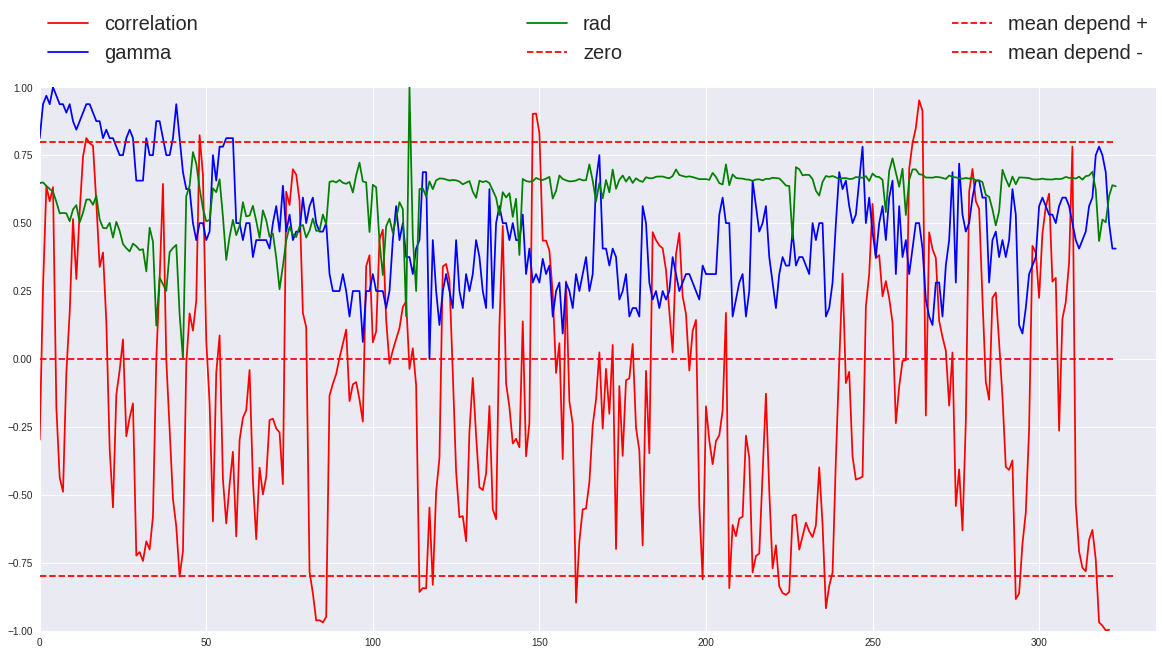

In [34]:
plt.figure(figsize=(20,10))
data1 = normalize(data.I_uR_h)
data2 = normalize(data.T_nT)
define_correlation(data1,data2)
avarage(data1, data2)
plt.show()

0.0 1.0
0.0 1.0


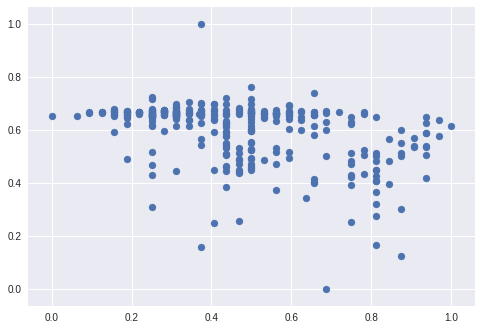

In [35]:
print(min(data1), max(data1))
print(min(data2), max(data2))
plt.scatter(data1, data2)

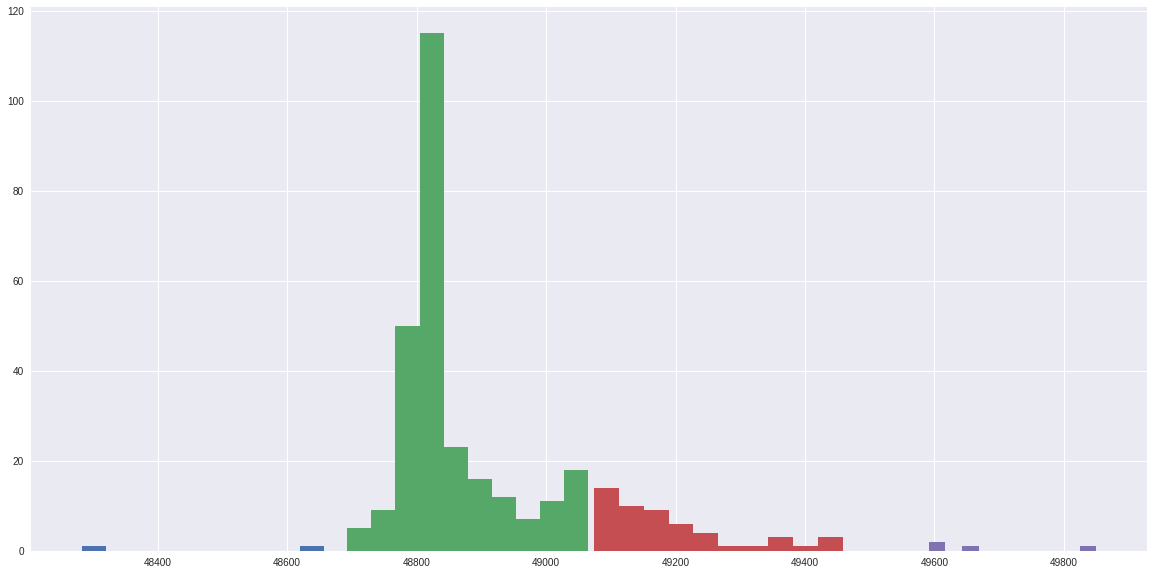

In [36]:
step = 4

gamma = data.I_uR_h
rad = data.T_nT
plt.figure(figsize=(20,10))


def part(arr,num,step):
    '''
    return interval number depend on step.
    num: part of interva.
    arr: list with data.
    step: number of interval. 
    '''
    min_num = arr.min()
    max_num = arr.max()
    dev = float(max_num - min_num) / step
    if num > step:
        return False
    return min_num + float(dev) * num

def interval_data(interval,data):
    '''
    interval: list with 2 numbers.
    interval[0] interval start, interval[1] interval end.
    data: list, with data.
    '''
    start = interval[0][0]
    end = interval[0][1]
    temp = []
    for i in data:
        if all([i >= start, i <= end]):
            temp.append(i)
    return temp


interval = list(map(lambda x: part(rad,x,step),range(step+1)))
result = list(map(lambda x: interval_data([interval[x:x+2]],rad),range(len(interval)-1)))

for i in result:
    plt.hist(i)
plt.show()

In [186]:
class KMeans(object):
    def __init__(self):
        self.centers = []
        self.clasters = []
        self.maxiter = 300

    def fit(self, data, num_clasters):
        self.data = data
        self.num_clasters = num_clasters
        self.centers = [list(choice(data)) for i in range(num_clasters)]
        self.claster_block()
        
    def init_clasters(self):
        self.clasters = [[] for i in range(self.num_clasters)]


    def dist(self, point1, point2):
        return math.sqrt(pow(point1[0]-point2[0], 2) + pow(point1[1]-point2[1],2))

    def min_dist(self, point):
        temp = [self.dist(x, point) for x in self.centers]
        return temp.index(min(temp))

    def new_centers(self):
        self.centers = list(map(lambda x: [np.array(x)[:, :1].mean(),np.array(x)[:, 1:].mean()], self.clasters))

    def claster_block(self):
        self.init_clasters()
        for point in self.data:
            c_index = self.min_dist(point)
            self.clasters[c_index].append(point)
            
    def center_diff(self, c_old, c_new):
        return [self.dist(c_old[i], c_new[i]) for i in range(len(c_new))]
            
    def predict(self):
        it = 0
        while 1:
            old_centers = self.centers
            self.new_centers()
            self.claster_block()
            it = it + 1
            print("step: {0}, centers distance: {1}".format(it, self.center_diff(old_centers,self.centers)))
            if old_centers == self.centers:
                break
            if it > self.maxiter:
                break
        return self.classify(), np.array(self.centers)
    
    def classify(self):
        return np.array([self.min_dist(point) for point in self.data])

In [190]:
X = [[data1[i], data2[i]] for i in range(len(data1))]

In [191]:
ktest = KMeans()
ktest.fit(X, 4)
y_kmean, centers = ktest.predict()

step: 1, centers distance: [0.016958126941697318, 0.1591258243033319, 0.15300501019438761, 0.2881620074887574]
step: 2, centers distance: [0.040315088866541594, 0.07039618532231783, 0.02889778928028101, 0.0294542938950899]
step: 3, centers distance: [0.009017662046346155, 0.052439713510236054, 0.014241753022024265, 0.0]
step: 4, centers distance: [0.012062780002511238, 0.023997031391235105, 0.017745096839801914, 0.011356508438741293]
step: 5, centers distance: [0.003090414220101065, 0.017608412815177946, 0.010883463559971959, 0.006740785499570768]
step: 6, centers distance: [0.0, 0.00688679206209559, 0.003508320833738739, 0.0]
step: 7, centers distance: [0.0, 0.00331542157027398, 0.001478845433598747, 0.0]
step: 8, centers distance: [0.0, 0.002760568007121107, 0.001272639892794074, 0.0]
step: 9, centers distance: [0.0, 0.0081313221859948, 0.0, 0.007224980084056027]
step: 10, centers distance: [0.0017945023061384715, 0.008650823224025883, 0.0, 0.0037224112202552777]
step: 11, centers di

Text(0.5,0.98,'KMeans result')

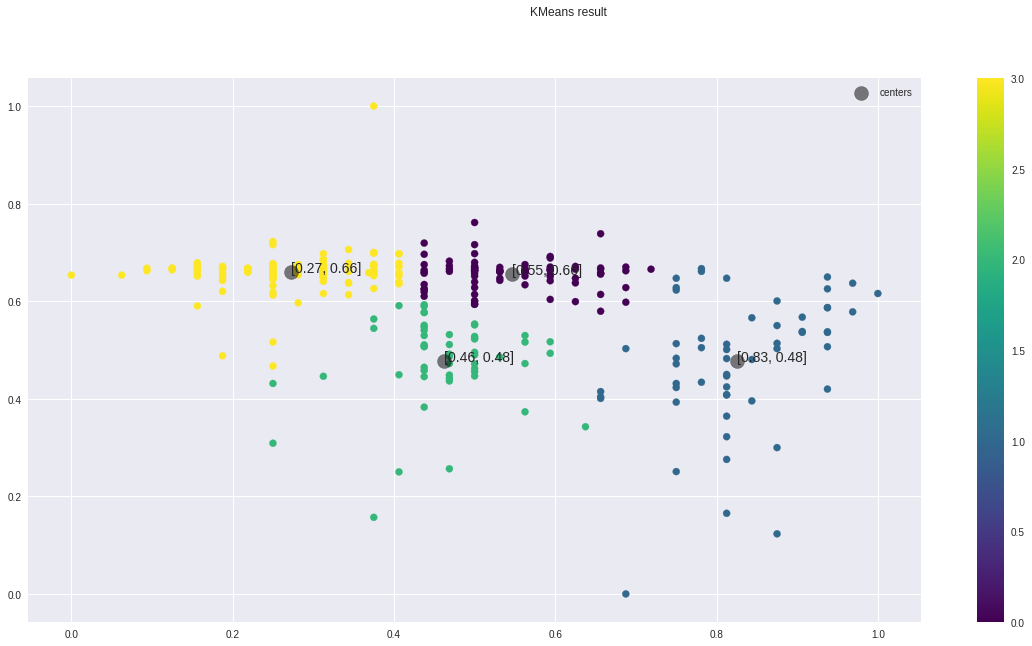

In [189]:
plt.figure(figsize=(20,10))
cb = plt.scatter(data1, data2, c=y_kmean, s=50, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5, label = 'centers')
for center in centers:
    plt.annotate(xy = center, s = f"{[round(i, 2) for i in center]}", fontsize  = 14)
plt.legend()
plt.colorbar(cb)
plt.suptitle('KMeans result')